In [19]:
import sys
import torchio as tio
import pandas as pd 
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import torchio.transforms as transforms
import torch
import torchvision.transforms as pytransforms
import sys
import numpy as np
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    Rand2DElastic,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    NormalizeIntensity,
    RandGaussianSmooth,
    Resize
)



sys.path.insert(0, '../../scripts/')
import data_loader
from helpers import miscellaneous as misc
from helpers import preprocessing2d as prep

CONFIG = misc.get_config()

In [20]:
CONFIG

{'RAW_DATA_DIR': 'data/raw/',
 'PROCESSED_DATA_DIR': 'data/processed/',
 'FLATTENED_DATA_DIR': 'data/raw/flattened/',
 'STRIPPED_DATA_DIR': 'data/stripped/',
 'SERIALIZED_MODELS': 'models/trained_models/',
 'METRICS_DIR': 'models/trained_history/',
 'ANNOTATIONS_DIR': 'data/annotations/',
 'CDR_DIR': 'data/tabular_data/tabular_data/CDR.csv',
 'GDSCALE_DIR': 'data/tabular_data/tabular_data/GDSCALE.csv',
 'MMSE_DIR': 'data/tabular_data/tabular_data/MMSE.csv',
 'MOCA_DIR': 'data/tabular_data/tabular_data/MOCA.csv',
 'NEUROBAT_DIR': 'data/tabular_data/tabular_data/NEUROBAT.csv',
 'PTDEMOG_DIR': 'data/tabular_data/tabular_data/PTDEMOG.csv',
 'TRAIN_LABELS_DIR': 'data/annotations/train_labels.csv',
 'TEST_LABELS_DIR': 'data/annotations/test_labels.csv',
 'PLOT_DIR_BINARY': 'reports/plots/',
 'SLICED_DATA_DIR': 'data/raw/slices/',
 'DATA_DIR_MODELS': '../models/checkpoints/',
 'STACKED': False,
 'MODEL': 'ResNet18',
 'NAME': 'ResNet18_CV',
 'DEVICE': 'gpu',
 'TRAIN_SIZE': 0.8,
 'K_FOLDS': 4,


In [21]:
SLICE = 'Center'
DIMENSION = CONFIG['DIMENSION']
TRANSFORMER = CONFIG['TRANSFORMER']


In [70]:
train_data = pd.read_csv('../../' + CONFIG['TRAIN_LABELS_DIR'])
test_data = pd.read_csv('../../' + CONFIG['TEST_LABELS_DIR'])

train_transform, val_transform = prep.get_transformer(TRANSFORMER)

In [71]:
#train_data.filename = train_data.filename.str.replace('raw/flattened', 'stripped', regex=True) #
test_data.filename = test_data.filename.str.replace('raw/flattened', 'stripped', regex=True) 
train_data.head()

,filename,Group,Subject
0,data/raw/flattened\ADNI_941_S_1311_MR_MPR__Gra...,MCI,941_S_1311
1,data/raw/flattened\ADNI_941_S_1311_MR_MPR__Gra...,MCI,941_S_1311
2,data/raw/flattened\ADNI_941_S_1311_MR_MPR-R__G...,MCI,941_S_1311
3,data/raw/flattened\ADNI_141_S_1255_MR_MPR__Gra...,MCI,141_S_1255
4,data/raw/flattened\ADNI_141_S_1255_MR_MPR__Gra...,MCI,141_S_1255


In [72]:
# train_transform, _ = prep.get_transformer('Monai_Augment')

test_img_processed = tio.ScalarImage("../../" + train_data.filename[0]).data.float()

#test_img_processed = tio.ScalarImage("../../data/stripped\ADNI_941_S_1311_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080313130949784_S27408_I97327.nii").data.unsqueeze(dim=3).float()
print(test_img_processed.size())

torch.Size([1, 192, 192, 160])


In [63]:
def imshow(img):
    plt.imshow(img)

In [64]:
train_data.filename[0]

'data/stripped\\ADNI_941_S_1311_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080313130949784_S27408_I97327.nii'

In [51]:
DIMENSION = 1

In [18]:

def save_slices(annotations, transform):
    
    for i in tqdm(range(len(annotations))):
        filename = annotations.filename.iloc[i]
        if isinstance(filename, str):
            name = filename.split('\\')[1]
            #name = name.replace('.nii', '.png')
        else:
            continue
        try:
            img = tio.ScalarImage("../../" + filename)
        except:
            print(f'Missing: {filename}')
            continue
        
        if SLICE == 'Center':
            nslice = img.data.size(DIMENSION)//2 #add more parameters for different slices, for example: 10%, 20%
        else:
            nslice = SLICE
        
        if SLICE:
            if DIMENSION == 1:
                assert img.data.size()[1] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[1]}'
                img = img.data[:, nslice, :, :]
            elif DIMENSION == 2:
                assert img.data.size()[2] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[2]}'
                img = img.data[:, :, nslice, :]
            elif DIMENSION == 3:
                assert img.data.size()[3] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[3]}'
                img = img.data[:, :, :, nslice]
        if i == 0:
            print("image size before transform: ", img.shape)
        try:
            img = transform(img.unsqueeze(dim=1))
        except Exception as e:
            print(e)
            print(filename)
            continue
            
        if i == 0:
            print("image size after transform: ", img.shape)
        """img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        npimg = np.squeeze(npimg)
        img = Image.fromarray(img.numpy()).uint8(I)"""
        img = tio.ScalarImage(tensor=img)
        img.save("../../" + CONFIG['SLICED_DATA_DIR'] + f'center/stripped/{DIMENSION}/' + name + ".nii")

# trainset
save_slices(train_data, val_transform)
save_slices(test_data, val_transform)

  0%|          | 0/1824 [00:00<?, ?it/s]

image size before transform:  torch.Size([1, 192, 160])
image size after transform:  torch.Size([1, 1, 256, 256])
Missing: data/stripped\ADNI_128_S_1408_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080223183402192_S45274_I91999.nii
Missing: data/stripped\ADNI_041_S_0679_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070214001636579_S17077_I40046.nii
Missing: data/stripped\ADNI_027_S_0644_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061222204755143_S15630_I34240.nii


  0%|          | 0/470 [00:00<?, ?it/s]

image size before transform:  torch.Size([1, 192, 160])
image size after transform:  torch.Size([1, 1, 256, 256])


## Dimension 1:

In [52]:
test_img_processed = tio.ScalarImage("../../" + CONFIG['SLICED_DATA_DIR'] + f'center/1/' + "ADNI_002_S_0938_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115856421_S19852_I118685" + ".nii")
plt.imshow(test_img_processed.data[0,:,:,0], cmap="gray")
plt.show()

FileNotFoundError: File not found: "..\..\data\raw\slices\center\1\ADNI_002_S_0938_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115856421_S19852_I118685.nii"

torch.Size([1, 192, 192, 160])


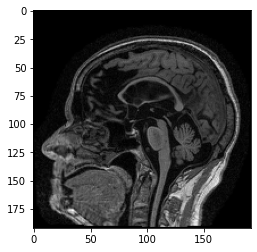

In [75]:
print(test_img_processed.squeeze(dim=3).size())
plt.imshow(test_img_processed.squeeze(dim=3).data[0,:,:,80], cmap="gray")
plt.show()

## Dimension 2:

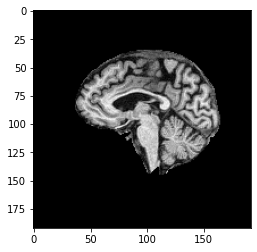

In [54]:
test_img_processed = tio.ScalarImage("../../" + CONFIG['SLICED_DATA_DIR'] + f'center/2/' + "ADNI_002_S_0938_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115856421_S19852_I118685" + ".nii")
plt.imshow(test_img_processed.data[0,:,:,0], cmap="gray")
plt.show()

## Dimension 3:

In [35]:
train_transform, _ = prep.get_transformer('Monai_Augment')

test_img_processed = train_transform(tio.ScalarImage("../../" + CONFIG['SLICED_DATA_DIR'] + f'center/3/' + "ADNI_002_S_0938_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115856421_S19852_I118685" + ".nii").data[:,:,:,0].float())
print(test_img_processed.size())

torch.Size([1, 256, 256])


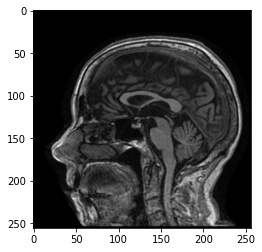

In [36]:
plt.imshow(test_img_processed.data[0,:,:], cmap="gray")
plt.show()

## Offset

Saving multiple slices [idx-n, idx, idx+n] per image

In [58]:
def save_slices_offset(annotations, transform, offset):
    
    for i in tqdm(range(len(annotations))):
        filename = annotations.filename.iloc[i]
        if isinstance(filename, str):
            name = filename.split('\\')[1]
            #name = name.replace('.nii', '.png')
        else:
            continue

        img = tio.ScalarImage("../../" + filename)
        
        if SLICE == 'Center':
            nslice = img.data.size(DIMENSION)//2 #add more parameters for different slices, for example: 10%, 20%
        else:
            nslice = SLICE
        
        if SLICE:
            if DIMENSION == 1:
                assert img.data.size()[1] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[1]}'
                img = img.data[:, [nslice - offset, nslice, nslice + offset], :, :]
            elif DIMENSION == 2:
                assert img.data.size()[2] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[2]}'
                img = img.data[:, :, [nslice - offset, nslice, nslice + offset], :]
            elif DIMENSION == 3:
                assert img.data.size()[3] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[3]}'
                img = img.data[:, :, :, [nslice - offset, nslice, nslice + offset]]
                
        if i == 1:
            print("image size before transform: ", img.shape)

        try:
            img = transform(img)
        except Exception as e:
            print(e)
            print(filename)
            continue
            
        if i == 1:
            print("image size after transform: ", img.shape)
            
        img = tio.ScalarImage(tensor=img)
        img.save("../../" + CONFIG['SLICED_DATA_DIR'] + f'offset/{DIMENSION}/' + name + ".nii")

In [61]:
def _crop_transformer():
    config = misc.get_config()
    return transforms.Compose(
        [
            ScaleIntensity(),
            EnsureType(),
            Resize((config['IMAGE_RESIZE1'],config['IMAGE_RESIZE2'], -1))
        ]
    )

In [62]:
train_transform, val_transform = _crop_transformer(), _crop_transformer()

In [63]:
save_slices_offset(train_data, train_transform, 3)
save_slices_offset(test_data, val_transform, 3)

  0%|          | 0/1824 [00:00<?, ?it/s]

image size before transform:  torch.Size([1, 192, 192, 3])
image size after transform:  torch.Size([1, 256, 256, 3])


  0%|          | 0/470 [00:00<?, ?it/s]

image size before transform:  torch.Size([1, 192, 192, 3])
image size after transform:  torch.Size([1, 256, 256, 3])


In [77]:
test = tio.ScalarImage("../../" + CONFIG['SLICED_DATA_DIR'] + f'offset/3/' + 'ADNI_137_S_0722_MR_MPR__GradWarp__N3__Scaled_Br_20070306180852008_S17295_I43022.nii')

In [84]:
test.data.size()

torch.Size([1, 256, 256, 3])

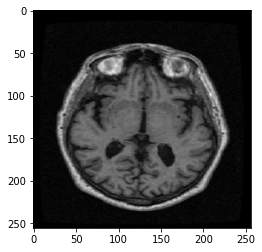

In [103]:
plt.imshow(test.data[0,:,:,0], cmap="gray")
plt.show()

## Multiple Planes

In [100]:
def save_slices_mplanes(annotations, transform):
    
    for i in tqdm(range(len(annotations))):
        filename = annotations.filename.iloc[i]
        if isinstance(filename, str):
            name = filename.split('\\')[1]
            #name = name.replace('.nii', '.png')
        else:
            continue

        img = tio.ScalarImage("../../" + filename)
        
        if SLICE == 'Center':
            nslice1 = img.data.size(1)//2 #add more parameters for different slices, for example: 10%, 20%
            nslice2 = img.data.size(2)//2 #add more parameters for different slices, for example: 10%, 20%
            nslice3 = img.data.size(3)//2 #add more parameters for different slices, for example: 10%, 20%

                
        else:
            nslice = SLICE
        
        if SLICE:
            assert img.data.size()[1] >= nslice1, f'[WARN] Nslice in dimension 1 is too large. Max allowed: {img.data.size()[1]}'
            assert img.data.size()[2] >= nslice2, f'[WARN] Nslice in dimension 2 is too large. Max allowed: {img.data.size()[2]}'
            assert img.data.size()[3] >= nslice3, f'[WARN] Nslice in dimension 3 is too large. Max allowed: {img.data.size()[3]}'

            img1 = img.data[:, nslice1, :, :]
            img2 = img.data[:, :, nslice2, :]
            img3 = img.data[:, :, :, nslice3]
            
            

                
        if i == 1:
            print("image size before transform: ", img.shape)

        try:
            
            img1 = transform(img1)
            img2 = transform(img2)
            img3 = transform(img3)
    
            img = torch.stack([img1, img2, img3]).squeeze(1)
                                    
        except Exception as e:
            print(e)
            print(filename)
            continue
            
        if i == 1:
            print("image size after transform: ", img.shape)
            
        img = tio.ScalarImage(tensor=img)
        img.save("../../" + CONFIG['SLICED_DATA_DIR'] + f'mplanes/' + name + ".nii")

In [112]:
save_slices_mplanes(train_data, train_transform)
save_slices_mplanes(test_data, val_transform)

  0%|          | 0/1824 [00:00<?, ?it/s]

image size before transform:  (1, 192, 192, 160)
image size after transform:  torch.Size([3, 256, 256, 1])


  0%|          | 0/470 [00:00<?, ?it/s]

image size before transform:  (1, 192, 192, 160)
image size after transform:  torch.Size([3, 256, 256, 1])


In [117]:
test = tio.ScalarImage("../../" + CONFIG['SLICED_DATA_DIR'] + f'mplanes/' + 'ADNI_137_S_0722_MR_MPR__GradWarp__N3__Scaled_Br_20070306180852008_S17295_I43022.nii')

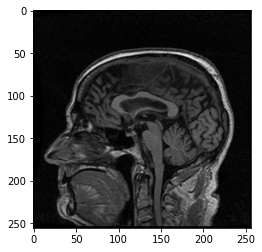

In [118]:
plt.imshow(test.data[2,:,:,], cmap="gray")
plt.show()

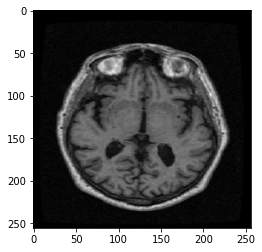

In [119]:
plt.imshow(test.data[0,:,:], cmap="gray")
plt.show()

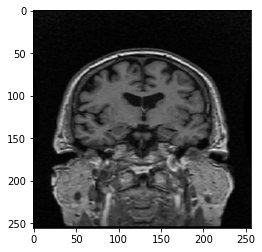

In [120]:
plt.imshow(test.data[1,:,:], cmap="gray")
plt.show()

torch.Size([3, 256, 256, 1])


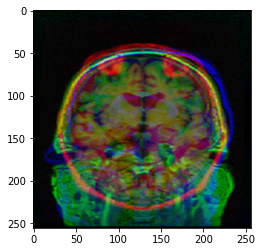

In [124]:
from torchvision.transforms.functional import to_pil_image
print(test.data.size())
plt.imshow(to_pil_image(test.data.squeeze(dim=3)), cmap='gray')
plt.show()

# Skull Stripping

In [ ]:
get

In [126]:
test = tio.ScalarImage("../../data/" + 'test2.nii')
test_stripped = tio.ScalarImage("../../data/" + 'test_stripped.nii')

In [122]:
test.shape

(1, 192, 192, 160)

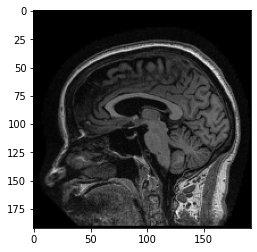

In [124]:
plt.imshow(test.data[0,:,:,80], cmap="gray")

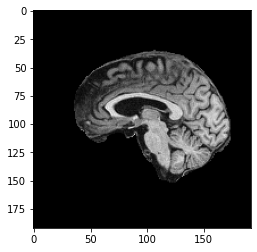

In [127]:
plt.imshow(test_stripped.data[0,:,:,80], cmap="gray")

In [130]:
test_data.filename

0      data/raw/flattened\ADNI_141_S_1052_MR_MPR__Gra...
1      data/raw/flattened\ADNI_141_S_1052_MR_MPR__Gra...
2      data/raw/flattened\ADNI_141_S_1052_MR_MPR__Gra...
3      data/raw/flattened\ADNI_141_S_0851_MR_MPR__Gra...
4      data/raw/flattened\ADNI_141_S_0851_MR_MPR-R__G...
                             ...                        
465    data/raw/flattened\ADNI_005_S_1341_MR_MPR__Gra...
466    data/raw/flattened\ADNI_005_S_1341_MR_MPR__Gra...
467    data/raw/flattened\ADNI_002_S_1018_MR_MPR__Gra...
468    data/raw/flattened\ADNI_002_S_1018_MR_MPR__Gra...
469    data/raw/flattened\ADNI_002_S_1018_MR_MPR__Gra...
Name: filename, Length: 470, dtype: object

In [149]:
import subprocess
import yaml
import csv


with open('../../CONFIG.yml', 'rb') as f:
    CONFIG = yaml.safe_load(f) 

def skull_strip_loop(annotations):

    filename = annotations

    with open(filename, 'r') as csvfile:
        datareader = csv.reader(csvfile)
        next(datareader)
        for row in datareader:
            filename = row[0]
            filename2 = filename.replace('data/raw/flattened', 'data/stripped')
            subprocess.run(f'python3 synthstrip-docker -i {filename} -o {filename2}')
            print(f'python3 synthstrip-docker -i {filename} -o {filename2}')
        
            break
    

if __name__ == '__main__':
    
    skull_strip_loop('../../' + CONFIG['TRAIN_LABELS_DIR'])
    skull_strip_loop('../../' + CONFIG['TEST_LABELS_DIR'])

data/raw/flattened\ADNI_941_S_1311_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080313130949784_S27408_I97327.nii


  0%|          | 0/39 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'filename'